<a href="https://colab.research.google.com/github/ekingit/DeepForecast/blob/main/4_reg_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from google.colab import drive #connect to drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/Colab\ Notebooks/weather_forecast/Data/data.py /content/data.py #copy data

from data import Weather_Data

Mounted at /content/gdrive


In [16]:
#params
num_epochs = 500
day_range = 21
seq_len = 14
lr = 1e-4
batch_size = 32
hidden_size = 64
num_layers = 1

In [17]:
nat_data = Weather_Data('/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Data/weather_prediction_dataset.csv','BASEL_temp_max')
train_data = nat_data.train
(in_train, out_train), (in_val, out_val), (in_test, out_test) = nat_data.data_chunks(21,0)
ds_train = TensorDataset(in_train, out_train)
ds_val = TensorDataset(in_val, out_val)
ds_test = TensorDataset(in_test, out_test)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False) #(list(91),32,21)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)


In [18]:
class ResBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.lin1 = nn.Linear(input_size, input_size // 2)
        self.norm2 = nn.LayerNorm(input_size // 2)
        self.lin2 = nn.Linear(input_size // 2, output_size)
        self.lin3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU()

    def forward(self, X):
        X = self.act(self.norm1(X))
        res = self.lin3(X)
        X = self.act(self.norm2(self.lin1(X)))
        X = self.lin2(X)
        return X + res

In [19]:
class regularized_local_LSTM(nn.Module):
    def __init__(self, seq_len, hidden_size, output_size):
        super().__init__()
        self.input_mlp = nn.Sequential(  # (input_size, seq_len)
            nn.Linear(seq_len, 2 * seq_len), # --> (input_size,4*seq_len)
            nn.ELU(),
            nn.Linear(2 * seq_len, 64)) # --> (input_size,128)
        #LSTM
        self.lstm = nn.LSTM(64, hidden_size, num_layers=1)
        #resblocks
        blocks = ResBlock(64, 64)
        self.blocks = nn.Sequential(blocks)
        #output
        self.out = nn.Linear(64, output_size)
        self.act = nn.ELU()
    def forward(self, X, H_in, c_in): #data(batch_size, seq_len) --> (batch_size,1)
        X = X.squeeze(-1) #(batch_size, seq_len,1) --> (batch_size, seq_len)
        X_vect = self.input_mlp(X).unsqueeze(0) #(batch_size, seq_len) --> (1,batch_size,128)
        Y_hat, (H_out, c_out) = self.lstm(X_vect, (H_in, c_in)) #Y_hat.shape(1,batch_size,128)
        X = self.act(self.blocks(Y_hat)).squeeze(0) #(1,batch_size,128) --> (batch_size,128)
        X = self.out(X) # (batch_size,128) --> (batch_size,1)
        return X, (H_out, c_out)

In [20]:
#initialize model and opt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weather_lstm = regularized_local_LSTM(seq_len, hidden_size, 1)
optimizer = torch.optim.Adam(weather_lstm.parameters(), lr=lr)
mean_loss = nn.MSELoss(reduction='sum')
train_loss = []

In [21]:
# number of parameters
# Compare: local_LSTM has 8500 parameters
num_model_params = 0
for param in weather_lstm.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d Parameters!" % (num_model_params))

-This Model Has 44165 Parameters!


In [25]:
ind = -2
save_model_path =f'/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Results/local/regularized_local_model.pth'
train_loss_list = []
val_loss_list = []
test_loss_list = []
a = time.time()
best_val = 0.5
for epoch in range(num_epochs):
    weather_lstm.train()
    weather_lstm.to(device)
    train_loss = 0
    for X, Y in dl_train:
        X_in = X[:,:seq_len].to(device)
        H = torch.zeros(1, X_in.shape[0], 64).to(device)
        c = torch.zeros(1, X_in.shape[0], 64).to(device)
        loss = 0
        for i in range(day_range-seq_len):
            Y = X[:,i+seq_len].to(device)
            Y_hat, (H, c) = weather_lstm(X_in, H, c)
            loss += mean_loss(Y_hat, Y)
            X_in = torch.cat([X_in[:,1:].squeeze(-1),Y_hat.detach()],1).unsqueeze(-1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/(len(dl_train.dataset)*(day_range-seq_len))
    train_loss_list.append(train_loss)
    #val_loss
    weather_lstm.eval()
    val_loss = 0
    for X, Y in dl_val:
      X_in = X[:,:seq_len].to(device)
      H = torch.zeros(1, X_in.shape[0], 64).to(device)
      c = torch.zeros(1, X_in.shape[0], 64).to(device)
      loss = 0
      for i in range(day_range-seq_len):
          target_seq_block = X[:,i+seq_len].to(device)
          Y_hat, (H, c) = weather_lstm(X_in, H, c)
          loss += mean_loss(Y_hat, target_seq_block)
          X_in = torch.cat([X_in[:,1:].squeeze(-1),Y_hat.detach()],1).unsqueeze(-1)
      val_loss += loss.item()
    val_loss = val_loss/(len(dl_val.dataset)*(day_range-seq_len))
    val_loss_list.append(val_loss)
    #test loss
    test_loss = 0
    for X, Y in dl_test:
      X_in = X[:,:seq_len].to(device)
      H = torch.zeros(1, X_in.shape[0], 64).to(device)
      c = torch.zeros(1, X_in.shape[0], 64).to(device)
      loss = 0
      for i in range(day_range-seq_len):
          target_seq_block = X[:,i+seq_len].to(device)
          Y_hat, (H, c) = weather_lstm(X_in, H, c)
          loss += mean_loss(Y_hat, target_seq_block)
          X_in = torch.cat([X_in[:,1:].squeeze(-1),Y_hat.detach()],1).unsqueeze(-1)
      test_loss += loss.item()
    test_loss = test_loss/(len(dl_test.dataset)*(day_range-seq_len))
    test_loss_list.append(test_loss)
    #save best loss
    if val_loss < best_val:
      best_val = val_loss
      best_epoch = epoch
      best_train = train_loss
      best_test = test_loss
      torch.save(weather_lstm.state_dict(), save_model_path)

    if epoch % 10 == 0:
        print(epoch, train_loss, val_loss, test_loss)
b = time.time()

0 0.409239258202345 0.2638158987220115 0.2641499343733469
10 0.2962611485644918 0.26185607437650393 0.24499806089897377
20 0.28838222224235627 0.2572687166373066 0.24200400156388097
30 0.2840089428972937 0.25400489032219303 0.2395005182822217
40 0.28103203448158226 0.25175243286334414 0.23790369419693258
50 0.27873744694186886 0.25018780532698315 0.23691287462028168
60 0.27682559725171857 0.24910289250947934 0.23628133274522525
70 0.2751374566274517 0.248432614604468 0.23596176443564607
80 0.2735873640457969 0.24809788830707527 0.2358999197193653
90 0.2721159898285276 0.24808301067273544 0.2360777740730519
100 0.2706970483566394 0.24838190133861035 0.23647128009874893
110 0.269314522934298 0.2489804536424128 0.2370334344890667
120 0.26796120790746536 0.24983413469486251 0.23773419847181274
130 0.2666305796630835 0.25088687616375044 0.23854228743435824
140 0.265334784708777 0.25206817072546256 0.2394186393177086
150 0.26408036036602656 0.25329684423671883 0.2403824032091287
160 0.262868

In [27]:
#write results to csv
ind = -2
results = {'model':'regularized_local_LSTM', 'seq_len':seq_len, 'hidden_size':hidden_size, 'num_layers':num_layers}
results['run_time'] = b-a
results['device'] = 'T4_GPU'
results['best_epoch'] = best_epoch
results['num_epoch'] = num_epochs
results['test_loss'] = best_test
results['val_loss'] = val_loss
results['train_loss'] = best_train

res_loc = '/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Results/local/Hyperparameter_Performance_Analysis.csv'
df1 = pd.DataFrame(results, index=[ind])
df1.to_csv(res_loc, mode='a', header=False)

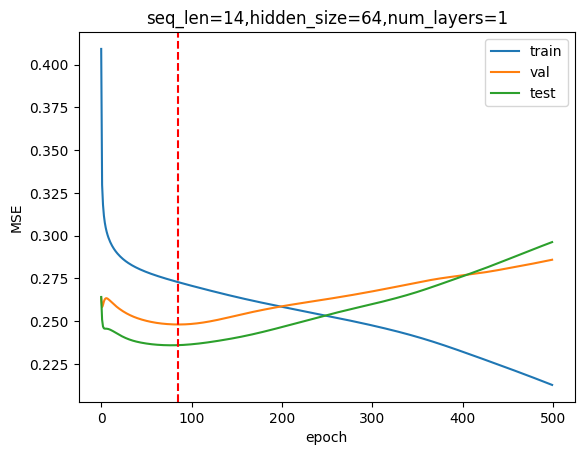

In [28]:
  #plot and save
  save_plot_path = f'/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Results/local/plt{-2}.png'
  train_loss_tens = torch.tensor(train_loss_list)
  val_loss_tens = torch.tensor(val_loss_list)
  plt.plot(train_loss_list,label='train')
  plt.plot(val_loss_list,label='val')
  plt.plot(test_loss_list,label='test')
  plt.axvline(x=best_epoch, color='r', linestyle='--')
  plt.title(f'seq_len={seq_len},hidden_size={hidden_size},num_layers={num_layers}')
  plt.xlabel('epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.savefig(save_plot_path)
  plt.show()